# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [49]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder 

pd.set_option('display.max_columns', None)

In [31]:
# 1. Завантажуємо дані
df = pd.read_csv('credit_risk_dataset.csv', sep=None, engine='python')

# 2. Виводимо розмір датасету
df.shape

(32581, 12)

In [32]:
# 3. Виводимо перших 5 рядків
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [33]:
# 4. Виводимо типи даних
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [34]:
# Перевірка пропущених значень
missing = df.isnull().sum()
missing[missing > 0]

person_emp_length     895
loan_int_rate        3116
dtype: int64

In [36]:
# 5.Перевіряємо розподіл цільової змінної (відсотк даних для кожного класу)
# Розподіл відтоку
churn_dist = df['loan_status'].value_counts()
churn_percent = df['loan_status'].value_counts(normalize=True) * 100

churn_percent

loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64

**Висновок:** Клас 0  (кредит сплачено) - 78%. Клас 1 (не сплачено кредит) - 22%. Маємо справу з незбалансованим датасетом (78% і 22%), один клас переважає інший майже у 4 рази. 


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [37]:
# Перевірка пропусків у всіх колонках
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

print("Пропуски у датасеті:")
print(pd.DataFrame({"Кількість": missing, "Відсоток": missing_percent}).sort_values(by="Відсоток", ascending=False))

Пропуски у датасеті:
                            Кількість  Відсоток
loan_int_rate                    3116  9.563856
person_emp_length                 895  2.747000
person_income                       0  0.000000
person_age                          0  0.000000
person_home_ownership               0  0.000000
loan_intent                         0  0.000000
loan_grade                          0  0.000000
loan_amnt                           0  0.000000
loan_status                         0  0.000000
loan_percent_income                 0  0.000000
cb_person_default_on_file           0  0.000000
cb_person_cred_hist_length          0  0.000000


In [38]:
# Заповнюємо пропуски медіаною
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())

print("Пропуски після заповнення:")
print(df.isnull().sum())


Пропуски після заповнення:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [39]:
# Статистика по числовим змінним
df.select_dtypes("number").describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.087372,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [47]:
# Знаходження і обробка викидів в колонці person_income з допомогою Interquartile range.
# 1. Розрахунок квартилів і IQR
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

# Межі
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Нижня межа: {lower_bound}, Верхня межа: {upper_bound}")

#  Кількість викидів
outliers = ((df['person_income'] < lower_bound) | (df['person_income'] > upper_bound)).sum()
print(f"Знайдено викидів: {outliers}")

# Обробка (варіант 1 – обрізаємо до меж)
df['person_income'] = np.where(df['person_income'] > upper_bound, upper_bound,
                               np.where(df['person_income'] < lower_bound, lower_bound, df['person_income']))

Q1: 38500.0, Q3: 79200.0, IQR: 40700.0
Нижня межа: -22550.0, Верхня межа: 140250.0
Знайдено викидів: 0



 Частоти для person_home_ownership:
person_home_ownership
RENT        50.477272
MORTGAGE    41.263313
OWN          7.931003
OTHER        0.328412
Name: proportion, dtype: float64

 Частоти для loan_intent:
loan_intent
EDUCATION            19.806022
MEDICAL              18.633559
VENTURE              17.553175
PERSONAL             16.945459
DEBTCONSOLIDATION    15.997053
HOMEIMPROVEMENT      11.064731
Name: proportion, dtype: float64

 Частоти для loan_grade:
loan_grade
A    33.077561
B    32.076977
C    19.821368
D    11.129186
E     2.958780
F     0.739695
G     0.196434
Name: proportion, dtype: float64

 Частоти для cb_person_default_on_file:
cb_person_default_on_file
N    82.367024
Y    17.632976
Name: proportion, dtype: float64


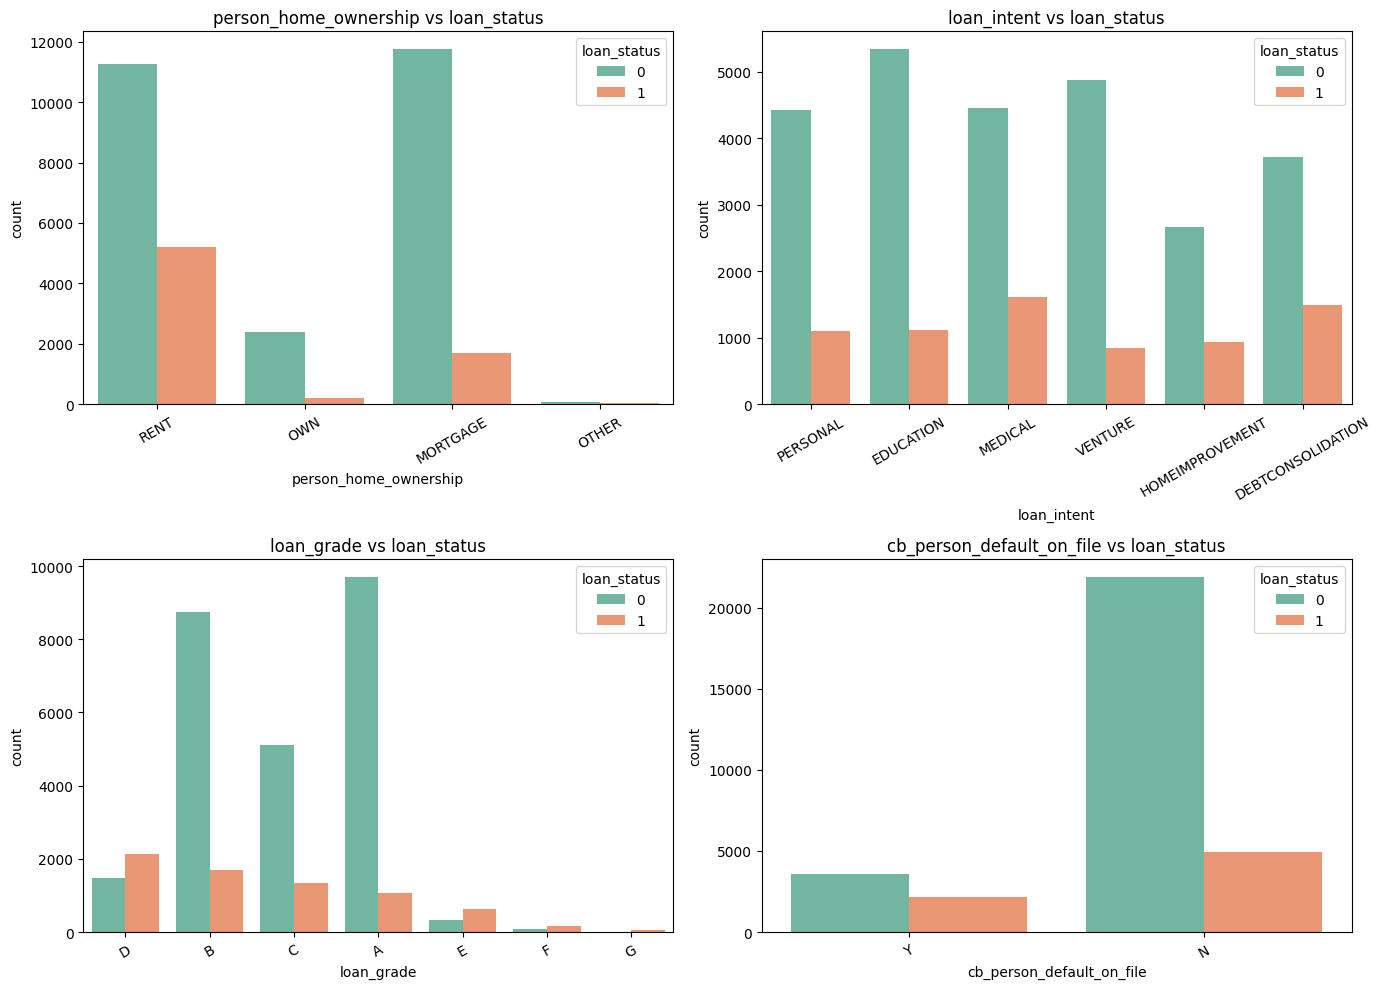

In [45]:
# 4. Категоріальні змінні
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Частоти категоріальних змінних
for col in categorical_cols:
    print(f"\n Частоти для {col}:")
    print(df[col].value_counts(normalize=True) * 100)  # % розподілу

# 5. Візуалізація розподілу категоріальних змінних відносно цільової
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue='loan_status', ax=axes[i], palette="Set2")
    axes[i].set_title(f"{col} vs loan_status")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

**Висновки із отриманих візуалізацій:**

* Аналіз person_home_ownership vs loan_status: найбільше клієнтів мають тип володіння житлом: RENT або MORTGAGE.
Дефолтів (loan_status = 1) відносно більше серед орендарів (RENT), ніж серед власників житла (OWN).
Отже, володіння власним житлом знижує ризик дефолту.

* Аналіз loan_intent vs loan_status: найбільше кредитів беруть на Education, Venture, Personal.
Вища частка дефолтів серед тих, хто бере кредит на Medical та Debt Consolidation.
Отже: мета кредиту суттєво впливає на ризик — “лікування” та “покриття боргів” є більш ризиковими.

* Аналіз loan_grade vs loan_status: 
кращі рейтинги (A, B) мають менший відсоток дефолтів.
Рейтинги D, E, F мають значно більше клієнтів у дефолті.
Отже, кредитний рейтинг - один з найсильніших предикторів ризику.

* Аналіз cb_person_default_on_file vs loan_status
Якщо в історії вже був дефолт (Y), то ймовірність нового дефолту набагато вища.
Клієнти без попередніх дефолтів (N) здебільшого повертають кредити.
Отже, попередній кредитний досвід дуже важливий фактор.


---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



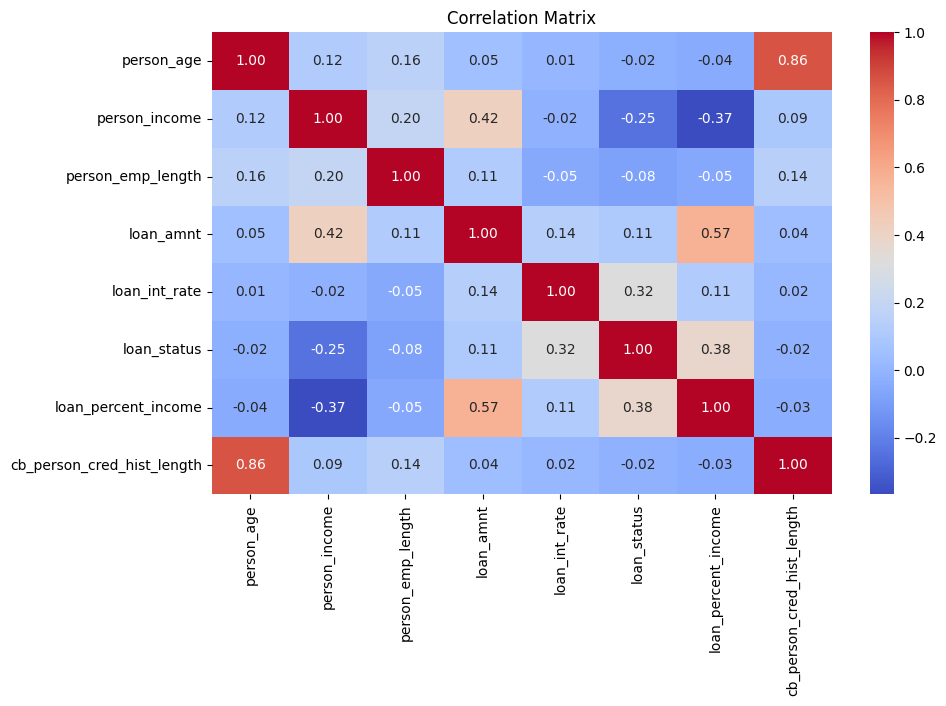

Фінальний розмірність X: (32581, 17)
Приклад даних:
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22        59000.0              123.0      35000          16.02   
1          21         9600.0                5.0       1000          11.14   
2          25         9600.0                1.0       5500          12.87   
3          23        65500.0                4.0      35000          15.23   
4          24        54400.0                8.0      35000          14.27   

   loan_percent_income  cb_person_cred_hist_length  loan_grade_enc  \
0                 0.59                           3             3.0   
1                 0.10                           2             1.0   
2                 0.57                           3             2.0   
3                 0.53                           2             2.0   
4                 0.55                           4             2.0   

   cb_person_default_on_file_enc  person_home_ownership_OTHER  \

In [52]:
# 3.1. Матриця кореляцій тільки для числових змінних
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 3.2. Кодування категоріальних змінних
df_fe = df.copy()

# loan_grade: порядкове кодування
grade_order = [["A", "B", "C", "D", "E", "F", "G"]]
oe = OrdinalEncoder(categories=grade_order)
df_fe["loan_grade_enc"] = oe.fit_transform(df_fe[["loan_grade"]])

# cb_person_default_on_file: бінарне кодування
df_fe["cb_person_default_on_file_enc"] = df_fe["cb_person_default_on_file"].map({"Y":1, "N":0})

# One-Hot Encoding для person_home_ownership та loan_intent
df_fe = pd.get_dummies(df_fe, columns=["person_home_ownership", "loan_intent"], drop_first=True)

# 3.3. Формуємо фінальний набір ознак
final_features = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "loan_grade_enc",
    "cb_person_default_on_file_enc"
] + [col for col in df_fe.columns if col.startswith("person_home_ownership_") or col.startswith("loan_intent_")]

print("Фінальний розмірність X:", X.shape)
print("Приклад даних:")
print(X.head())


---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

# Ділимо дані на X та y. 

X = df_fe[final_features]
y = df_fe["loan_status"]

# 2. Поділ на тренувальну і тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Масштабування числових ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Навчання моделі
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 5. Прогнози
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# 6. Оцінка якості
print("=== TRAIN ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("=== TEST ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

=== TRAIN ===
Accuracy: 0.8527470841006752
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     20378
           1       0.74      0.51      0.60      5686

    accuracy                           0.85     26064
   macro avg       0.81      0.73      0.75     26064
weighted avg       0.84      0.85      0.84     26064

=== TEST ===
Accuracy: 0.8565290777965322
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5095
           1       0.75      0.52      0.61      1422

    accuracy                           0.86      6517
   macro avg       0.81      0.73      0.76      6517
weighted avg       0.85      0.86      0.85      6517

Confusion matrix (test):
[[4848  247]
 [ 688  734]]



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


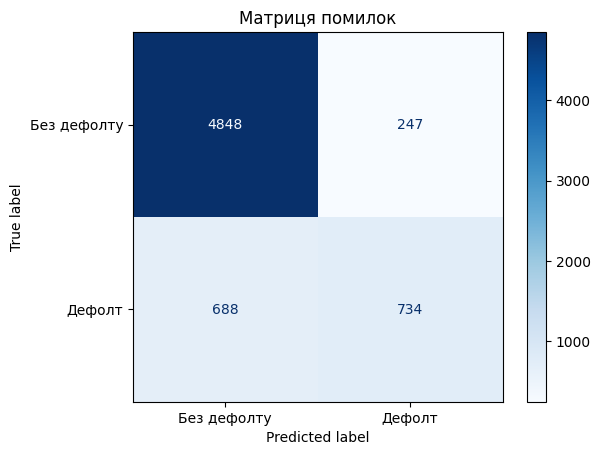

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# будуємо матрицю помилок для тестових даних
cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Без дефолту', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# обчислюємо метрики
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("МЕТРИКИ ЯКОСТІ МОДЕЛІ:")
print(f"Accuracy (Точність):    {accuracy:.3f}")
print(f"Precision (Влучність):  {precision:.3f}")
print(f"Recall (Повнота):       {recall:.3f}")
print(f"F1-score:               {f1:.3f}")


МЕТРИКИ ЯКОСТІ МОДЕЛІ:
Accuracy (Точність):    0.857
Precision (Влучність):  0.748
Recall (Повнота):       0.516
F1-score:               0.611


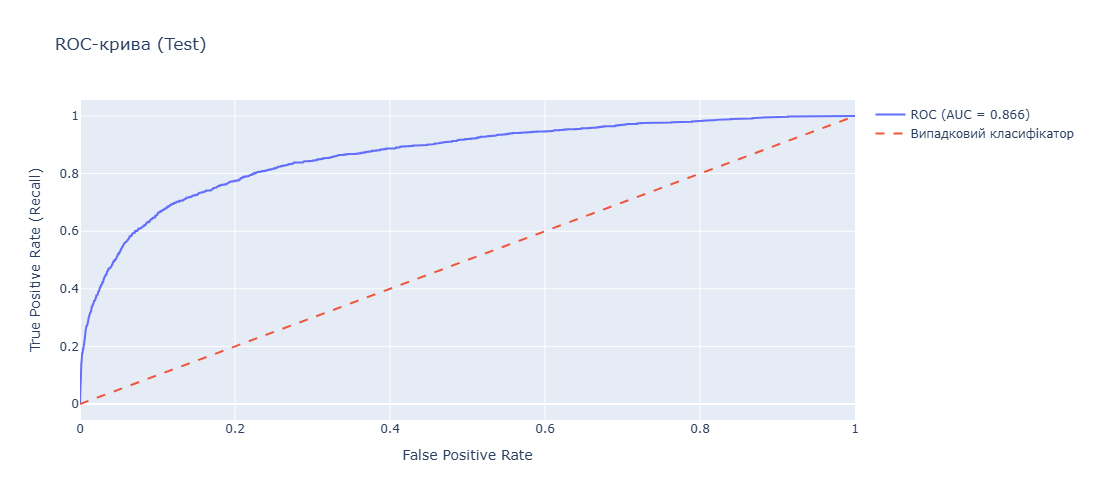

AUC = 0.866


In [62]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, roc_auc_score

# отримуємо ймовірності дефолту для тестової вибірки
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# обчислюємо ROC-криву
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# візуалізація ROC-кривої
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', 
                         name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', 
                         line=dict(dash='dash'), name='Випадковий класифікатор'))

fig.update_layout(
    title='ROC-крива (Test)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate (Recall)',
    height=500
)
fig.show()

print(f"AUC = {auc:.3f}")


AUC = 0.866. У нас хороша модель.

In [65]:
# Отримуємо коефіцієнти моделі
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_reg.coef_[0],
    'abs_coefficient': np.abs(log_reg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

# Виводимо топ-10 найбільш важливих ознак
print("Топ-10 ознак за абсолютним значенням коефіцієнтів:")
print(feature_importance.head(10))

Топ-10 ознак за абсолютним значенням коефіцієнтів:
                       feature  coefficient  abs_coefficient
5          loan_percent_income     1.224211         1.224211
7               loan_grade_enc     1.120265         1.120265
3                    loan_amnt    -0.450086         0.450086
10   person_home_ownership_OWN    -0.423678         0.423678
16         loan_intent_VENTURE    -0.392512         0.392512
11  person_home_ownership_RENT     0.382780         0.382780
12       loan_intent_EDUCATION    -0.315561         0.315561
15        loan_intent_PERSONAL    -0.202113         0.202113
1                person_income    -0.149183         0.149183
4                loan_int_rate    -0.070719         0.070719


**Висновок:**

Accuracy (Точність) = 0.857. Це досить високий показник, але accuracy сам по собі не завжди відображає якість для незбалансованих класів.
Precision (Влучність) = 0.748. Тобто, з усіх передбачених позитивних випадків ~75% були правильними.
Recall (Повнота) = 0.516. Модель знаходить лише ~52% всіх реальних позитивних випадків. Це низький показник, що означає велику кількість пропущених позитивних випадків. F1-score = 0.611
Гармонічне середнє між Precision і Recall. F1 вказує на середню якість моделі при балансі між помилками першого та другого роду.
AUC = 0.866. Показує, що модель добре відрізняє позитивні та негативні випадки. Це дуже гарний результат для задачі класифікації.

Загалом модель має хорошу здатність відрізняти класи (AUC високий), але для практичного застосування є проблема з пропущеними позитивними випадками (низький Recall). Тобто модель може бути небезпечна, якщо важливо не пропускати позичальників з ризиком.

По ознаках:

loan_percent_income та loan_grade_enc – мають найбільший вплив на рішення моделі.
Вища частка позики від доходу - підвищує ризик (позитивний коефіцієнт).
Клас кредиту також сильно впливає.
loan_amnt – негативний вплив, тобто більші кредити можуть асоціюватися з меншим ризиком/іншим класом (залежить від кодування).
Власність на житло (OWN та RENT) – помітний вплив, може відображати фінансову стабільність.
loan_intent (VENTURE, EDUCATION, PERSONAL) – показує, для яких цілей позичальник бере кредит, і це важливо для прогнозу.
person_income та loan_int_rate – відносно невеликий вплив у цій моделі.


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



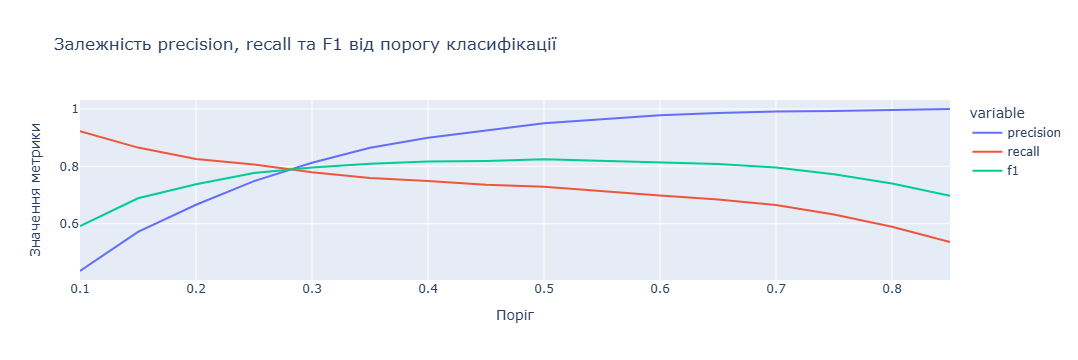

In [73]:
# Аналіз різних порогів
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom),
        'recall': recall_score(y_test, y_pred_custom),
        'f1': f1_score(y_test, y_pred_custom)
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

# Візуалізація
fig = px.line(
    metrics_df.melt(id_vars='threshold'),
    x='threshold',
    y='value',
    color='variable',
    title='Залежність precision, recall та F1 від порогу класифікації',
    labels={'value': 'Значення метрики', 'threshold': 'Поріг'}
)
fig.show()

Оптимальний поріг буде у точці, де перетинаються 3 метрики - 0,28.

Обираємо модуль в залежності від місій банку. Найкритичнішим буде варіант, коли взятий кредит не буде повернуто. Тому доцільно робити акцент на precision.


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.
